In [113]:
import pandas as pd
from os import listdir
from pandas.errors import EmptyDataError
from unidecode import unidecode
import seaborn as sns
import re
from wordcloud import WordCloud
from gensim.models import Word2Vec, KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
from random import shuffle
import pickle

sns.set(
    rc = {
        'figure.figsize': (10, 8)
    },
    style = 'darkgrid'
)

In [2]:
 df = pd.concat([
    pd.read_csv('data/concatenated/'+filename)
    for filename in
    listdir('data/concatenated')
])

# Dictionares

In [3]:
grouping_orders = {
    "website": {
        "columns_before": ['website', 'sentiment'],
        "groupby": ["website"],
        "columns_after": ['fakt', 'gazeta', 'wyborcza'] 
    },
    "brand": {
        "columns_before": ['brand', 'sentiment'],
        "groupby": ["brand"],
        "columns_after": ['agora', 'ringier'] 
    },
    "country": {
        "columns_before": ['country', 'sentiment'],
        "groupby": ["country"],
        "columns_after": ['de/ch', 'pl'] 
    }
}

In [4]:
brand_keys = {
    "pl": {
        "agora": ['wyborcza', 'gazeta']
    },
    "de/ch": {
        "ringier": ['fakt', 'onet', 'newsweek']
    },
    'us': {
        "discovery": ['tvn']
    },
    'ru': {
        "sjegodnia": ['sputnik']
    }
}

In [86]:
osoba = ['wzór', 'wróg'] # wzór, wróg, nieprzyjaciel
partia = ['postęp', 'zacofanie'] # rozwój, dobrobyt, 
poglad = ['swoboda', 'reżim'] # chaos, totalitaryzm, racjonalizm
kraj = ['sojusznik', 'wróg'] # ostoja, oaza, 
keyword_reference_words = {
    'najwyższy': {
        'types': ['country'],
        'references': ['sprawiedliwość', 'niesprawiedliwość'],
    },
    'imigranci': {
        'types': ['country', 'global'],
        'references': ['obywatele', 'terroryści'],
    },
    'ekologia': {
        'types': ['global'],
        'references': ['', ''],
    },
    'emigracja': {
        'types': ['country'],
        'references': ['szansa', 'ucieczka'],
    },
    'pis': {
        'types': ['country'],
        'references': partia,
    },
    'obywatelska': {
        'types': ['country'],
        'references': partia,
    },
    'duda': {
        'types': ['country'],
        'references': osoba,
    },
    'morawiecki': {
        'types': ['country'],
        'references': osoba,
    },
    'szydło': {
        'types': ['country'],
        'references': osoba,
    },
    'kaczyński': {
        'types': ['country'],
        'references': osoba,
    },
    'kwaśniewski': {
        'types': ['country'],
        'references': osoba,
    },
    'lewica': {
        'types': ['country'],
        'references': poglad,
    },
    'prawica': {
        'types': ['country'],
        'references': poglad,
    },
    'lgbt': {
        'types': ['global', 'country'],
        'references': ['tolerancja', ''],
    },
    'europa': {
        'types': ['global'],
        'references': ['unia', 'rozłam'],
    },
    'rosja': {
        'types': ['global', 'country'],
        'references': kraj,
    },
    'usa': {
        'types': ['global', 'country'],
        'references': kraj,
    },
    'premier': {
        'types': ['country'],
        'references': osoba,
    },
    'prezydent': {
        'types': ['country'],
        'references': osoba,
    },
    'opozycja': {
        'types': ['country'],
        'references': partia,
    },
    'rząd': {
        'types': ['country'],
        'references': partia,
    },
    'sejm': {
        'types': ['country'],
        'references': partia,
    },
    'polska': {
        'types': ['global', 'country'],
        'references': ['oaza', ''],
    },
    'putin': {
        'types': ['global', 'country'],
        'references': ['sojusznik', 'wróg'],
    },
    'trump': {
        'types': ['global', 'country'],
        'references': ['sojusznik', 'wróg'],
    },
    'ukraina': {
        'types': ['global', 'country'],
        'references': kraj,
    },
    'media': {
        'types': ['country'],
        'references': ['', ''],
    },
    'bank': {
        'types': ['global'],
        'references': ['bezpieczeństwo', 'wyzysk'],
    },
    'niemcy': {
        'types': ['global', 'country'],
        'references': kraj,
    },
    'papież': {
        'types': ['global'],
        'references': osoba,
    },
    'kościół': {
        'types': ['country'],
        'references': ['oparcie', 'firma'],
    },
    'korwin': {
        'types': ['country'],
        'references': osoba,
    },
    'rydzyk': {
        'types': ['country'],
        'references': osoba,
    },
    'feminizm': {
        'types': ['country', 'global'],
        'references': ['równość', 'patriarchat'],
    },
    'miller': {
        'types': ['country'],
        'references': osoba,
    },
}

In [ ]:
decoder = {
    '%B1': 'ą',
    '%BF': 'ż',
    '%B3': 'ł',
    '%B6': 'ś',
    '%F1': 'ń',
    '%F3': 'ó'
}
with open('keywords', 'r') as f:
    raws = f.read().split('\n')
keyword_dict = {}
for raw in raws:
    tmp_keyword = raw
    for d1, d2 in decoder.items():
        tmp_keyword = tmp_keyword.replace(d1, d2)
    keyword_dict[tmp_keyword] = ''

In [ ]:
keyword_regex = {
    'pis': r"\Dpis\D|prawo i sprawiedliwość"
}

# Analyze

## Get emotions data from polish wordnet

In [22]:
# http://plwordnet.pwr.wroc.pl//wordnet/download-wordnet?key=1iflsj&file=4.0
# extract one file (słownik_anotacji_emocjonlanej) to home directory

In [23]:
emotions = pd.read_csv('~/słownik_anotacji_emocjonlanej.csv')[['lemat', 'emocje']].dropna()

In [24]:
emotions.head()

,lemat,emocje
2,abstrakcyjny,wstręt;złość;zaskoczenie
3,abstrakcyjny,wstręt;złość
10,adorator,złość;radość
11,adorator,złość;cieszenie się na;radość;wstręt
18,afektowany,złość;smutek


In [25]:
emotions['emocje'] = emotions['emocje'].str.replace(':', ';')

In [26]:
pairs = [
    ('złosć', 'negatywny'),
    ('zlość', 'negatywny'),
    ('złośc', 'negatywny'),
    ('złość wstręt', 'negatywny'),
    ('złość: nieużyteczność', 'negatywny'),
    ('złóść', 'negatywny'),
    ('bład', 'negatywny'),
    ('brzydota', 'negatywny'),
    ('błąd', 'negatywny'),
    ('gniew', 'negatywny'),
    ('krzywda', 'negatywny'),
    ('nieszczęscie', 'negatywny'),
    ('nieszczęście', 'negatywny'),
    ('nieużyteczność', 'negatywny'),
    ('złość', 'negatywny'),
    ('strach', 'negatywny'),
    ('strach wstręt', 'negatywny'),
    ('smute', 'negatywny'),
    ('smutek', 'negatywny'),
    ('wstęt', 'negatywny'),
    ('niewiedza', 'negatywny'),
    ('negatywny wstręt', 'negatywny'),
    ('negatywnyk', 'negatywny'),
    ('negatywnyk: negatywny', 'negatywny'),
    ('wstrę', 'negatywny'),
    ('wstręt', 'negatywny'),
    ('wstręt: negatywny', 'negatywny'),
    ('negatywnyt', 'negatywny'),
    ('s mutek', 'negatywny'),
    ('wstret', 'negatywny'),
    ('smitek', 'negatywny'),
    (' negatywny', 'negatywny'),
    
    ('cieszenie sie', 'pozytywny'),
    ('cieszenie sie na', 'pozytywny'),
    ('cieszenie się na coś oczekiwanego', 'pozytywny'),
    ('dobro', 'pozytywny'),
    ('cieszenie sie', 'pozytywny'),
    ('radoć', 'pozytywny'),
    ('radość', 'pozytywny'),
    ('radość: piękno', 'pozytywny'),
    ('radość: szczęście', 'pozytywny'),
    ('zaufanie', 'pozytywny'),
    ('cieszenie się', 'pozytywny'),
    ('cieszenie się na', 'pozytywny'),
    ('ciesznie się na', 'pozytywny'),
    ('piękno', 'pozytywny'),
    ('pozytywny: piękno', 'pozytywny'),
    ('pozytywny: szczęście', 'pozytywny'),
    ('prawda', 'pozytywny'),
    ('radosć', 'pozytywny'),
    ('pozytywny: pozytywny', 'pozytywny'),
    ('radośc', 'pozytywny'),
    ('szczęście', 'pozytywny'),
    ('użyteczność', 'pozytywny'),
    ('wiedza', 'pozytywny'),
    ('zufanie', 'pozytywny'),
    ('pozytywny na', 'pozytywny'),
    (' pozytywny', 'pozytywny'),
    
    ('zaskoczenie czymś nieprzewidywanym', ''),
    ('oczekiwanie na', ''),
    (' czymś nieprzewidywanym', ''),
    ('-', ''),
    ('zaskoczenie', ''),
    ('pozytywnynegatywny', ''),
]

In [27]:
for pair in pairs:
    emotions['emocje'] = emotions['emocje'].str.replace(pair[0], pair[1])

In [28]:
emotions = pd.concat([
    emotions['lemat'],
    emotions['emocje']\
        .str.get_dummies(sep = ';')\
], axis = 1)

In [29]:
emotions.loc[
    emotions['pozytywny'] == emotions['negatywny']
, 'ambiguous'] = True

In [30]:
len(emotions)

56420

In [31]:
emotions = emotions[emotions['ambiguous'].isna()]
emotions = emotions.drop('ambiguous', axis = 1)

In [32]:
len(emotions)

47477

In [33]:
emotions['negatywny'].sum()

31505

In [34]:
emotions['pozytywny'].sum()

15972

In [35]:
emotions.sample(5).head()

,lemat,negatywny,pozytywny
107694,nieskwapliwość,0,1
154808,spokojniuchny,0,1
109344,subtelność,0,1
74825,uznaniowy,1,0
155569,kombinacyjnie,0,1


In [36]:
emotions = emotions.drop('negatywny', axis = 1)

In [37]:
emotions.loc[emotions['pozytywny'] == 0, 'pozytywny'] = -1

In [38]:
emotions.columns = ['lemat', 'sentyment']

In [39]:
emotions = emotions.drop_duplicates()

In [40]:
emotions.sample(5).head()

,lemat,sentyment
68449,letargiczny,-1
8470,wytłumaczyć,1
45315,człowiek wielkiego ducha,1
168779,fetyszystyczny,-1
27600,unifikator,1


In [41]:
emotions_dict = {x[0]:x[1] for x in emotions.values}

## Titles/shorts

In [42]:
emotions.sample(5).head()

,lemat,sentyment
161843,pośpieszyć,1
8634,zadra,-1
84046,niezły,1
131006,marzenie ściętej głowy,-1
44288,panienka spod latarni,-1


In [43]:
emotion_words = emotions_dict.keys()

In [44]:
df['sentiment'] = df['long'].str.lower().apply(lambda x: sum([emotions_dict[a] 
                                         for a in str(x).split(' ')
                                         if a in emotion_words]))

In [45]:
grouped_data = {}
for key, grouping_order in grouping_orders.items():
    data_dict = {}
    for keyword in keywords:
        data_dict[keyword] = df\
            [(df[keyword] == 1)&(df['sentiment'] != 0)]\
            [grouping_order['columns_before']]\
            .groupby(grouping_order['groupby'])\
            .mean()\
            .values\
            .flatten()
    res = pd.DataFrame().from_dict(
        data_dict,
        'index',
        columns = grouping_order['columns_after']
    )
    res = (res - res.mean())/res.std()
    grouped_data[key] = res

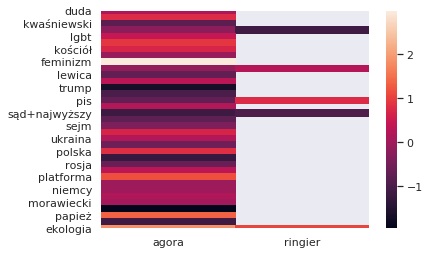

In [46]:
sns.heatmap(grouped_data['brand']);

In [47]:
# compare that chart (two websites in one company), and two websites from two different companies

## Regex

In [48]:
wc = WordCloud()

In [49]:
keyword_patterns = ['duda', 'dudy', 'dude']

In [50]:
found_records = df[['long']][
    df['long'].str.lower().str.contains(r'|'.join(keyword_patterns)) == True
].values.flatten()

In [51]:
keyword_words_before = []
keyword_words_after = []
for record in found_records:
    tmp_string_list = re.sub(r'\W+', ' ', record).lower().split(' ')
    keyword_idxs = [n for n, x in enumerate(tmp_string_list) if x in keyword_patterns]
    max_idx = len(tmp_string_list)
    for keyword_idx in keyword_idxs:
        if keyword_idx < max_idx - 2 and keyword_idx > 1:
            keyword_context_before = tmp_string_list[keyword_idx-2 : keyword_idx]
            keyword_words_before.append(keyword_context_before[0])
            keyword_words_before.append(keyword_context_before[1])
            keyword_context_after = tmp_string_list[keyword_idx+1 : keyword_idx+3]
            keyword_words_after.append(keyword_context_after[0])
            keyword_words_after.append(keyword_context_after[1])

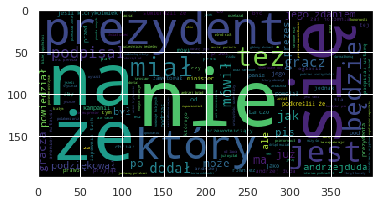

In [52]:
plt.imshow(wc.generate(" ".join(keyword_words_after)))

## Word2Vec

In [7]:
df['whole_string'] = (
    df['title'] + '. ' +
    df['short'] + '. ' +
    df['long']
)

In [8]:
def make_sentences(df):
    sentences = []
    for record in df['whole_string'].dropna().str.lower():
        if record != None:
            for sentence in record.split('.'):
                sentences.append(re.sub(r'\W+', ' ', sentence).lower().strip().split(' '))
    return sentences

In [9]:
models = {}
models['model'] = Word2Vec(make_sentences(df), size = 100, min_count = 10, window = 6, workers = 2)
for country, brand_dict in brand_keys.items():
    models[country] = {}
    for brand_name in df['brand'].unique():
        models[country][brand_name] = {}
        brand_data = make_sentences(df[df['brand'] == brand_name])
        models[country][brand_name]['model'] = Word2Vec(brand_data, min_count = 10, window = 5, workers = 10)

In [10]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)
def calculate_angle(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return abs(np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))))

In [58]:
def calculate_scores(point_of_view):
    model_dict_keys = (
        ('us', 'discovery'),
        ('pl', 'agora'),
        ('de/ch', 'ringier'),
        ('ru', 'sjegodnia'),
    )
    results = []
    df_idx = []
    for keyword, k_properties in keyword_reference_words.items():
        try:
            if '' not in k_properties['references'] and point_of_view in k_properties['types']:
                row = []
                reference = k_properties['references']
                for model_dict_key in model_dict_keys:
                    # cosine similarity with one reference
#                     keyword_v = models[model_dict_key[0]][model_dict_key[1]]['model'].wv[keyword]
#                     reference_v = models['model'].wv[reference[0]]
#                     score = distance.cosine(keyword_v, reference_v)
                    # cosine similarity with two references
                    keyword_vector = models[model_dict_key[0]][model_dict_key[1]]['model'].wv[keyword]
                    positive_vector = models['model'].wv[reference[0]]
                    negative_vector = models['model'].wv[reference[1]]
                    positive_angle = calculate_angle(keyword_vector, positive_vector)
                    negative_angle = calculate_angle(keyword_vector, negative_vector)
                    score = positive_angle / (positive_angle+negative_angle)
                    row.append(score)
                results.append(row)
                df_idx.append(keyword)
        except KeyError:
            print(keyword)
    
    return pd.DataFrame(results, columns = ['discovery [US]', 'agora [PL]', 'ringier [EU]', 'sjegodnia [RU]'], index = df_idx)

In [59]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

feminizm


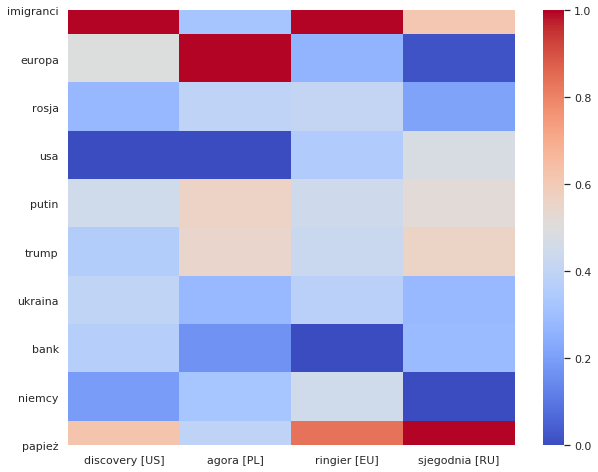

In [122]:
vector_results = calculate_scores('global')
sns.heatmap(normalize(vector_results), cmap = 'coolwarm', center = 0.5)

In [53]:
models['model'].wv.most_similar('polska')

[('europa', 0.7494603991508484),
 ('rosja', 0.7234011888504028),
 ('ukraina', 0.7123920917510986),
 ('niepodległa', 0.6711875200271606),
 ('grecja', 0.649996280670166),
 ('francja', 0.6484516859054565),
 ('ameryka', 0.6483502984046936),
 ('turcja', 0.6436651349067688),
 ('bułgaria', 0.6362323760986328),
 ('serbia', 0.6219605803489685)]

In [117]:
with open('~/models', 'wb') as f:
    pickle.dump(models, f)

In [119]:
with open('~/models', 'rb') as f:
    models = pickle.load(f)

## Vectors validation with neutral words

In [120]:
random_words = list(models['model'].wv.vocab.keys())
shuffle(random_words)
random_sample = random_words[:10]

In [121]:
models

{'model': <gensim.models.word2vec.Word2Vec at 0x7f65fceceda0>,
 'pl': {'ringier': {'model': <gensim.models.word2vec.Word2Vec at 0x7f65ebbc7278>},
  'discovery': {'model': <gensim.models.word2vec.Word2Vec at 0x7f65e53b9898>},
  'agora': {'model': <gensim.models.word2vec.Word2Vec at 0x7f65db54d550>},
  'sjegodnia': {'model': <gensim.models.word2vec.Word2Vec at 0x7f65ca4e1ba8>}},
 'de/ch': {'ringier': {'model': <gensim.models.word2vec.Word2Vec at 0x7f65c41004e0>},
  'discovery': {'model': <gensim.models.word2vec.Word2Vec at 0x7f65b2888240>},
  'agora': {'model': <gensim.models.word2vec.Word2Vec at 0x7f65eb494a58>},
  'sjegodnia': {'model': <gensim.models.word2vec.Word2Vec at 0x7f65fa966940>}},
 'us': {'ringier': {'model': <gensim.models.word2vec.Word2Vec at 0x7f65c7f90198>},
  'discovery': {'model': <gensim.models.word2vec.Word2Vec at 0x7f65e89b6240>},
  'agora': {'model': <gensim.models.word2vec.Word2Vec at 0x7f65e989e6d8>},
  'sjegodnia': {'model': <gensim.models.word2vec.Word2Vec at 0x

In [ ]:
for model in models['']

In [111]:
random_sample

['przywołuje',
 'oparli',
 'osłony',
 'czołówek',
 'opamiętajcie',
 'pomorska',
 'położyłam',
 'stylizowanym',
 'niepodzielną',
 'zbliżona']

## Convert to 2-d

In [53]:
vectors = models['model'].wv.vectors
words = models['model'].wv.vocab

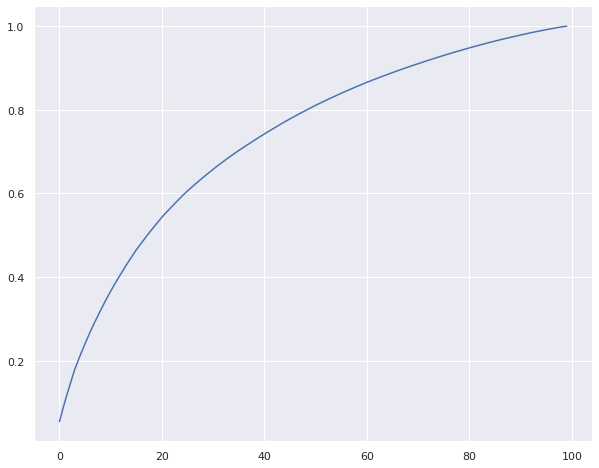

In [54]:
pca = PCA(n_components = 100).fit(vectors)
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [55]:
pca_vectors = PCA(n_components = 90).fit_transform(vectors)

In [56]:
tsne_vectors = TSNE(
    n_components = 2, 
    n_jobs = 10,
    learning_rate = 200,
    n_iter = 1000,
    n_iter_without_progress = 50
).fit_transform(pca_vectors)

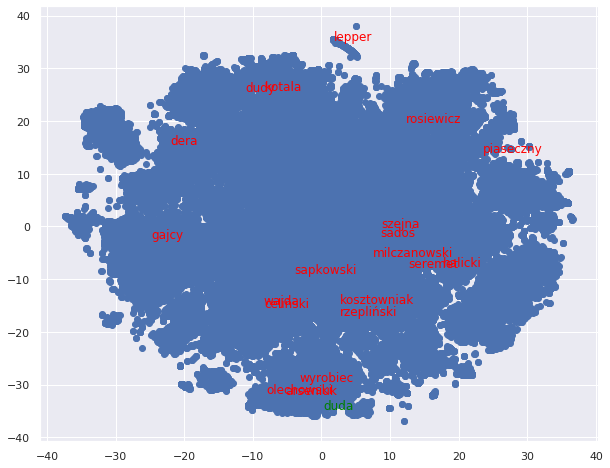

In [59]:
plt.plot(figsize = (12, 12))
plt.scatter(
    [x[0] for x in tsne_vectors],
    [x[1] for x in tsne_vectors],
)
selected_word = 'duda'
idx = list(models['model'].wv.vocab.keys()).index(selected_word)
plt.annotate(selected_word, (tsne_vectors[idx][0], tsne_vectors[idx][1]), color = 'green')
similar_words = [x[0] for x in models['model'].wv.most_similar(positive=[selected_word], topn=20)]
for similar_word in similar_words:
    idx = list(models['model'].wv.vocab.keys()).index(similar_word)
    plt.annotate(similar_word, (tsne_vectors[idx][0], tsne_vectors[idx][1]), color = 'red')